In [182]:
from shapely.geometry import Point, mapping, shape
from fiona import collection
import fiona
import rasterio.features
import datacube
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datacube.utils import geometry
from datacube.api.grid_workflow import GridWorkflow
from datacube.api.query import query_group_by
import numpy as np
import itertools
from datetime import date, datetime, timedelta
import otps
import sys
from otps import TimePoint, predict_tide
from dateutil.relativedelta import relativedelta

# Id 28 segmented centroid lon and lat 151.69-23.18
#Id 108 segmented centroid lon and lat 151.23-22.99
# 178 segmented centroid lon and lat 150.99-22.84
#Id 221 segmented centroid lon and lat 151.55-22.93
#Id 239 segmented centroid lon and lat 151.63-23.73
#LON="--lon_range '(151.68, 151.70)'"  # Gladstone
#LAT="--lat_range '(-23.17, -23.19)'"
lon_range = ''
# COMMENT OUT lon_range IN CASE DEALING WITH POLYGON
#lon_range = '(151.0, 151.50)'
lat_range = '(-22, -23)'

time_period=('1986-01-01', '2017-01-01')
filepath =''
# COMMENT OUT IN CASE DEALING WITH LON/LAT AND MAKE SURE PASS lon AND lat as TIDE POST from csv model file.
filepath = '/g/data/u46/users/bxb547/otps/vector_data/ecog_320_aus_albers.shp'
dc=datacube.Datacube(app='test')
#gw=GridWorkflow(dc.index)

tp=list()
all_times = list()
lon = 151.23
lat = -22.99
products = ['ls5_pq_albers', 'ls7_pq_albers', 'ls8_pq_albers']
#products = ['ls5_pq_albers', 'ls8_pq_albers']

try:
    with fiona.open(filepath) as Input:
        crs = geometry.CRS(str(Input.crs_wkt))
        for feature in Input:
            lon = feature['properties']['lon']
            lat = feature['properties']['lat']
            Id = feature['properties']['Id']
        # Darwin test
        #130.55,-12.20
        #130.28,-12.50
        #130.85,-12.60
            if Id == 108:
                print lon ,lat, Id
                first_geometry = feature['geometry']
            #print first_geometry
                geom = geometry.Geometry(first_geometry, crs=crs)
                                
                for source in products:
                    time_range = ('1986-01-01', '2003-03-01') if source == 'ls7_pq_albers' else time_period
                    print "finding datasets for " + source + " in " + str(time_range)
                    ds = dc.find_datasets(product=source, time=time_range, geopolygon=geom, group_by='solar_day')
                    group_by = query_group_by(group_by='solar_day')
                    sources = dc.group_datasets(ds, group_by)
                    if len(ds) > 0 :
                        all_times = all_times + [dd for dd in sources.time.data.astype('M8[s]').astype('O').tolist()] 
                    all_times = sorted(all_times)            
                break
except IOError as e:
    print ("Polygon File not found ")
                
  
if len(lon_range) > 0:
    for source in products:
        time_range = ('1986-01-01', '2003-03-01') if source == 'ls7_pq_albers' else time_period
        print "finding datasets for " + source + " in " + str(time_range)
        ds = dc.find_datasets(product=source, time=time_range, x = eval(lon_range), y= eval(lat_range))
        group_by = query_group_by(group_by='solar_day')
        sources = dc.group_datasets(ds, group_by)
        if len(ds) > 0 :
            all_times = all_times + [dd for dd in sources.time.data.astype('M8[s]').astype('O').tolist()] 
            all_times = sorted(all_times)
    

print "tide post selected " + str(lon) + str(lat)
for dt in all_times:
    tp.append(TimePoint(lon, lat, dt))
tides = predict_tide(tp)
tide_dic = dict()

for tt in tides:
    tide_dic[datetime.strptime(tt.timepoint.timestamp.isoformat()[0:19], "%Y-%m-%dT%H:%M:%S")] = tt.tide_m

my_data = sorted(tide_dic.items(), key=lambda x: x[1])
print sorted([[x[0].strftime('%Y-%m-%d'), x[1]] for x in my_data])

            

151.23 -22.99 108
finding datasets for ls5_pq_albers in ('1986-01-01', '2017-01-01')
finding datasets for ls7_pq_albers in ('1986-01-01', '2003-03-01')
finding datasets for ls8_pq_albers in ('1986-01-01', '2017-01-01')
tide post selected 151.23-22.99
[['1986-08-21', 0.909], ['1987-09-25', 1.224], ['1987-10-11', 0.279], ['1987-11-12', -0.394], ['1987-11-28', -0.705], ['1987-12-14', -0.274], ['1987-12-30', 0.721], ['1988-01-15', 0.763], ['1988-01-31', 1.625], ['1988-02-16', 2.413], ['1988-03-19', 1.384], ['1988-04-20', -0.315], ['1988-05-06', -0.6], ['1988-05-22', -0.776], ['1988-06-07', -1.178], ['1988-06-23', -0.752], ['1988-07-09', -0.182], ['1988-07-25', -0.201], ['1988-08-10', 0.719], ['1988-08-26', 1.39], ['1988-09-11', 1.34], ['1988-09-27', 1.63], ['1988-10-13', 1.236], ['1988-10-29', 0.143], ['1988-11-14', -0.02], ['1988-11-30', -0.444], ['1989-01-01', -0.074], ['1989-01-17', 0.799], ['1989-02-18', 1.735], ['1989-03-06', 2.213], ['1989-03-22', 1.457], ['1989-06-10', -0.906], ['19

In [183]:
EPOCH="--epoch 40" #default epoch 2
DEB="--debug"   # To get detail of date/time and tide heights
# LS7FL="--ls7fl"  To include LS7 datasets
YEAR="--year_range 2010-2017"
date_ranges=(datetime(2010,1,1) , datetime(2017,1,1))
LR="--date_all_1 "  # This is set for other than 50 % AND for low tides
HR=" --date_all_2 "  # This is used for 50 % and also used for high percentage of LOW/HIGH
QT="'"
#CRS="--crs " + CRS
#print CRSVAR

PERCC="40"  #for high percentage
LOW_PER="20" #For low percentage
ODIR="--odir /g/data/u46/users/bxb547/otps/testdata2/"
PER ="--per " + PERCC #Default percentage 10
EBBFLOW="--ebb_flow"
if "50" in PERCC:
    PERC = "25"
else:
    PERC = PERCC
print ("percentage accepted for high tide percentage " + PERCC + " and for low tide percentage " + LOW_PER)

max_height=my_data[-1][1]
min_height=my_data[0][1]
dr = float(max_height)-float(min_height)

lmr = float(min_height) + dr*float(LOW_PER)*0.01   # low tide max range
hlr = float(max_height) - dr*float(PERC)*0.01   # high tide range

if "50" in PERCC:
    date_middle = sorted([[x[0][0].strftime('%Y-%m-%d'), x[0][1]] for x  in my_data if (x[0][1] >= lmr) & (x[0][1] <= hlr) ])
    print (" 50 PERCENTAGE sorted date tide list " + str(len(date_middle)))
    print date_middle
    print ""
    st_middle = ['"{0}, {1}"'.format(w[0], w[1]) for w in date_middle]
    st_middle = '{0}'.format(', '.join(st_middle))
    # print st_middle
    #%run inter_tidal_wf.py $LON $LAT $YEAR $HR $QT$st_middle$QT $PER $EPOCH $DEB
    #%run inter_tidal_wf.py $POLY $TIDE_POST $YEAR $HR $QT$st_middle$QT $PER $EPOCH $DEB
    #%run inter_tidal_poly.py $POLY $TIDE_POST $YEAR $HR $QT$st_middle$QT $PER $EPOCH $DEB $ODIR
else:
    #date_low = sorted([[x[0][0].strftime('%Y-%m-%d'), x[0][1]] for x in my_data if x[0][1] <= lmr])
    #date_high = sorted([[x[0][0].strftime('%Y-%m-%d'), x[0][1]] for x in my_data if x[0][1] >= hlr])
    date_low = sorted([[x[0].strftime('%Y-%m-%d'), x[1]] for x in my_data if (x[1] <= lmr)])
    date_high = sorted([[x[0].strftime('%Y-%m-%d'), x[1]] for x in my_data if (x[1] >= hlr)])
    #print ("LOW TIDE sorted date list " + str(len(date_low)) + "\n " + str(date_low))
    #print ("LOW TIDE in sorted height " + str([[x[0].strftime('%Y-%m-%d'), x[1]] for x  in my_data if x[1] <= lmr]))
    #print ("HIGH TIDE sorted date list " + str(len(date_high)) + "\n " + str(date_high))
    #print ("HIGH TIDE in sorted height " + str([[x[0].strftime('%Y-%m-%d'), x[1]] for x  in my_data if x[1] >= hlr]))
    st_low = ['"{0}, {1}"'.format(w[0], w[1]) for w in date_low]
    st_low = '{0}'.format(', '.join(st_low))
    st_high = ['"{0}, {1}"'.format(w[0], w[1]) for w in date_high]
    st_high = '{0}'.format(', '.join(st_high))
    
    #%run inter_tidal_wf.py $LON $LAT $YEAR $LR $QT$st_low$QT $HR $QT$st_high$QT $PER $EPOCH $DEB
    #%run inter_tidal_wf.py $POLY $TIDE_POST $YEAR $LR $QT$st_low$QT $HR $QT$st_high$QT $PER $EPOCH $DEB
    #%run inter_tidal_poly.py $POLY $EBBFLOW $CRSVAR $TIDE_POST $YEAR $LR $QT$st_low$QT $HR $QT$st_high$QT $PER $EPOCH $DEB $ODIR
    date_low = sorted([[x[0], x[1]] for x in my_data if (x[1] <= lmr) &
                                (x[0] >= date_ranges[0]) & (x[0] <= date_ranges[1])])
    date_high = sorted([[x[0], x[1]] for x in my_data if (x[1] >= hlr) &
                                (x[0] >= date_ranges[0]) & (x[0] <= date_ranges[1])])
    print "LOW LISTING" + str([[x[0].strftime('%Y-%m-%d'), x[1]] for x  in date_low])
    print "HIGH LISTING" + str([[x[0].strftime('%Y-%m-%d'), x[1]] for x  in date_high])

    

percentage accepted for high tide percentage 40 and for low tide percentage 20
LOW LISTING[['2010-05-03', -0.504], ['2010-06-04', -0.855], ['2011-06-07', -0.926], ['2011-06-23', -0.869], ['2011-07-09', -1.079], ['2011-07-25', -0.578], ['2013-04-04', -0.665], ['2013-06-28', -0.851], ['2013-07-14', -0.545], ['2013-07-30', -0.844], ['2013-08-15', -1.071], ['2014-02-23', -0.579], ['2014-07-17', -0.835], ['2014-08-18', -0.825], ['2014-09-03', -0.963], ['2015-03-14', -0.592], ['2015-08-05', -0.72], ['2015-09-06', -0.823], ['2015-09-22', -0.824], ['2016-03-16', -0.582], ['2016-04-01', -0.593], ['2016-08-23', -0.527], ['2016-09-24', -0.837], ['2016-10-10', -0.666]]
HIGH LISTING[['2010-01-11', 0.977], ['2010-01-27', 1.243], ['2010-02-12', 1.642], ['2010-08-23', 0.968], ['2011-02-15', 1.18], ['2011-04-04', 1.155], ['2011-09-11', 1.242], ['2011-09-27', 2.062], ['2013-04-09', 1.255], ['2013-04-25', 1.379], ['2013-11-03', 2.002], ['2013-12-05', 1.59], ['2014-04-28', 1.249], ['2014-05-14', 1.165], [

In [184]:
from datetime import timedelta
from operator import itemgetter

tp = list()
tide_dict = dict()
dates=list()
#lon = 151.69
#lat = -23.18


for x in date_low:
    dates.append(x[0])
for x in date_high:
    dates.append(x[0])
#print time_low
#print dates
ndate_list=list()
mnt=timedelta(minutes=15)
for dt in dates:
    #dt = datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")
    ndate_list.append(dt-mnt)
    ndate_list.append(dt)
    ndate_list.append(dt+mnt)
for dt in ndate_list:
    tp.append(TimePoint(lon, lat, dt))
tides = predict_tide(tp)

for tt in tides:
    tide_dict[datetime.strptime(tt.timepoint.timestamp.isoformat()[0:19], "%Y-%m-%dT%H:%M:%S")] = tt.tide_m

tmp_lt = sorted(tide_dict.items(), key=lambda x: x[0])

tmp_lt = [[tmp_lt[i+1][0].strftime("%Y-%m-%d"), 'ph'] \
         if tmp_lt[i][1] < tmp_lt[i+1][1] and tmp_lt[i+2][1] <  tmp_lt[i+1][1]  else \
        [tmp_lt[i+1][0].strftime("%Y-%m-%d"), 'pl'] if tmp_lt[i][1] > tmp_lt[i+1][1] and \
        tmp_lt[i+2][1] >  tmp_lt[i+1][1]  else [tmp_lt[i+1][0].strftime("%Y-%m-%d"),'f'] \
        if tmp_lt[i][1] < tmp_lt[i+2][1] else [tmp_lt[i+1][0].strftime("%Y-%m-%d"),'e'] \
         for i in range(0, len(tmp_lt), 3)]

ebb_flow = str([tt for tt in tmp_lt ])                  
#print tmp_lt
#print "for entire low high ebb flow" + ebb_flow
key = set(e[0].strftime("%Y-%m-%d") for e in date_low)

ebb_flow_low = [ff for ff in eval(ebb_flow) if ff[0] in key]
key = set(e[0].strftime("%Y-%m-%d") for e in date_high)
#print sorted(key)
#print date_low
#print date_high
ebb_flow_high = [ff for ff in eval(ebb_flow) if ff[0] in key]
print "low ebb flow " + str(ebb_flow_low)
print "high ebb flow " + str(ebb_flow_high)


low ebb flow [['2010-05-03', 'f'], ['2010-06-04', 'e'], ['2011-06-07', 'f'], ['2011-06-23', 'e'], ['2011-07-09', 'e'], ['2011-07-25', 'e'], ['2013-04-04', 'e'], ['2013-06-28', 'f'], ['2013-07-14', 'f'], ['2013-07-30', 'e'], ['2013-08-15', 'e'], ['2014-02-23', 'e'], ['2014-07-17', 'f'], ['2014-08-18', 'e'], ['2014-09-03', 'e'], ['2015-03-14', 'e'], ['2015-08-05', 'f'], ['2015-09-06', 'e'], ['2015-09-22', 'e'], ['2016-03-16', 'e'], ['2016-04-01', 'e'], ['2016-08-23', 'f'], ['2016-09-24', 'e'], ['2016-10-10', 'e']]
high ebb flow [['2010-01-11', 'e'], ['2010-01-27', 'e'], ['2010-02-12', 'e'], ['2010-08-23', 'e'], ['2011-02-15', 'e'], ['2011-04-04', 'ph'], ['2011-09-11', 'e'], ['2011-09-27', 'e'], ['2013-04-09', 'e'], ['2013-04-25', 'e'], ['2013-11-03', 'e'], ['2013-12-05', 'f'], ['2014-04-28', 'e'], ['2014-05-14', 'e'], ['2014-11-06', 'e'], ['2014-11-22', 'e'], ['2014-12-08', 'f'], ['2014-12-24', 'f'], ['2015-05-17', 'e'], ['2015-06-02', 'e'], ['2015-11-09', 'e'], ['2015-11-25', 'e'], ['20

In [48]:
import numpy as np
import itertools
from datetime import date, datetime, timedelta
import otps
import sys
from otps import TimePoint, predict_tide
from dateutil.relativedelta import relativedelta

#lon = 151.23
#lat = -22.99

def date_range(start_date, end_date, increment, period):
    result = []
    nxt = start_date
    delta = relativedelta(**{period:increment})
    while nxt <= end_date:
        result.append(nxt)
        nxt += delta
    return result

start = datetime(2010,1,1,0,22,16)
end = datetime(2017,1,1)

tp = list()

tide_det = list()
print "starting", str(datetime.now())
for string_date in date_range(start, end, 1, 'hours'):
    dt = datetime.strptime(str(string_date), "%Y-%m-%d %H:%M:%S")
    tp.append(TimePoint(lon, lat, dt))

print "added to the list", str(datetime.now())
tides = predict_tide(tp)
print "received from predict tides", str(datetime.now())
for tt in tides:
    tide_det.append([tt.timepoint.timestamp.isoformat()[0:10], tt.tide_m])
print "finished", str(datetime.now())


starting 2017-04-17 16:22:37.330042
added to the list 2017-04-17 16:22:40.071815
received from predict tides 2017-04-17 16:22:50.073791
finished 2017-04-17 16:22:50.251775


DATE LOW[['2010-05-03', -0.504], ['2010-06-04', -0.855], ['2011-06-07', -0.926], ['2011-06-23', -0.869], ['2011-07-09', -1.079], ['2011-07-25', -0.578], ['2013-04-04', -0.665], ['2013-06-28', -0.851], ['2013-07-14', -0.545], ['2013-07-30', -0.844], ['2013-08-15', -1.071], ['2014-02-23', -0.579], ['2014-07-17', -0.835], ['2014-08-18', -0.825], ['2014-09-03', -0.963], ['2015-03-14', -0.592], ['2015-08-05', -0.72], ['2015-09-06', -0.823], ['2015-09-22', -0.824], ['2016-03-16', -0.582], ['2016-04-01', -0.593], ['2016-08-23', -0.527], ['2016-09-24', -0.837], ['2016-10-10', -0.666]]

DATE HIGH[['2010-01-11', 0.977], ['2010-01-27', 1.243], ['2010-02-12', 1.642], ['2010-08-23', 0.968], ['2011-02-15', 1.18], ['2011-04-04', 1.155], ['2011-09-11', 1.242], ['2011-09-27', 2.062], ['2013-04-09', 1.255], ['2013-04-25', 1.379], ['2013-11-03', 2.002], ['2013-12-05', 1.59], ['2014-04-28', 1.249], ['2014-05-14', 1.165], ['2014-11-06', 1.922], ['2014-11-22', 1.941], ['2014-12-08', 1.611], ['2014-12-24', 1

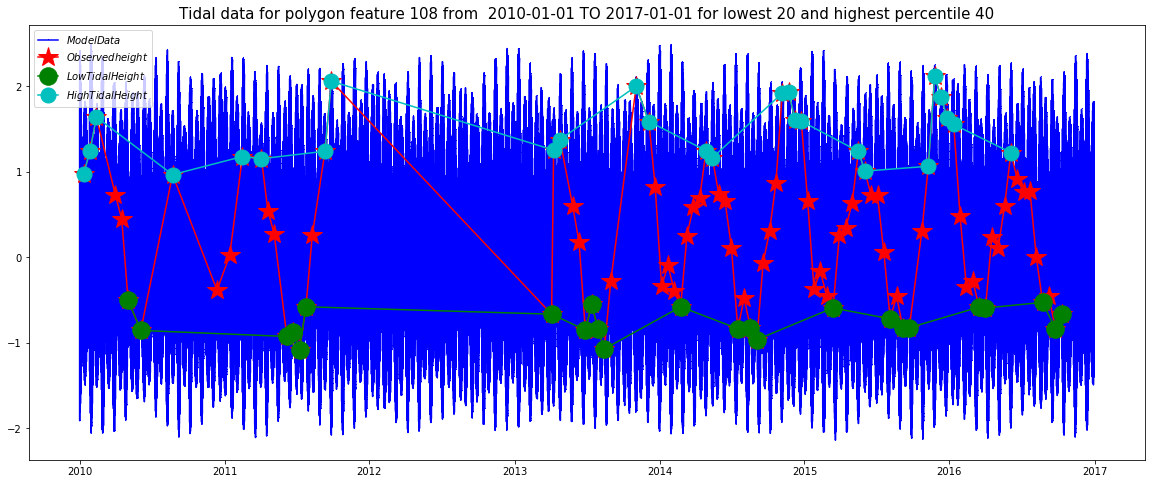

In [185]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import datetime
import itertools


print "DATE LOW" + str([[e[0].strftime("%Y-%m-%d"), e[1]] for e in date_low])
print "\nDATE HIGH" + str([[e[0].strftime("%Y-%m-%d"), e[1]] for e in date_high])
model_date=[x[0] for x in tide_det]
model_height=[x[1] for x in tide_det]
all_data = sorted([[x[0].strftime('%Y-%m-%d'), x[1]] for x in my_data if (x[0] >= date_ranges[0]) &
                                 (x[0] <= date_ranges[1])])
all_date = sorted([x[0] for x in all_data])
all_height = [x[1] for x in all_data]
low_date = [x[0].strftime("%Y-%m-%d") for x in date_low]
low_height = [x[1] for x in date_low]
high_date = [x[0].strftime("%Y-%m-%d") for x in date_high]
high_height = [x[1] for x in date_high]
efl = [x[1] for x in ebb_flow_low]
efh = [x[1] for x in ebb_flow_high]
labl = efh
print efh
col_dic = {'f':'red', 'e':'green', 'ph':'purple', 'pl':'yellow'}
#colr= ['red' if 'f' in l else 'green' if 'e' in l else 'purple' if 'ph' in l else 'yellow' for l in labl]
#ebb_date = [x[0] for x in eval(ebb_flow)]
#print len(ebb_date)
ebb_class = [x[1] for x in eval(ebb_flow)]
print "EBB FLOW LOW count " + str(len(ebb_flow_low)) + " and " + str(ebb_flow_low)
print "EBB FLOW HIGH count " + str(len(ebb_flow_high)) + " and " + str(ebb_flow_high)
#df_obs = pd.DataFrame({'Observerdheight' : HT}, index=pd.DatetimeIndex(LT_DATE))
low_df=pd.DataFrame(date_low)
cols=['date', 'height']
low_df.columns = cols
all_data=pd.DataFrame(all_data)
all_data.columns = cols
#print all_data
df10 = pd.DataFrame({'ModelHeight' : model_height}, index=pd.DatetimeIndex(model_date))
df1 = pd.DataFrame({'LowTidalHeight' : low_height}, index=pd.DatetimeIndex(low_date))
df3 = pd.DataFrame({'HighTidalHeight' : high_height}, index=pd.DatetimeIndex(high_date))
df2 = pd.DataFrame({'Observedheight' : all_height}, index=pd.DatetimeIndex(all_date))
df4 = pd.DataFrame(dict(high_date=high_date, high=high_height, efh=efh))
df5 = pd.DataFrame(dict(low_date=low_date, low=low_height, efl=efl))

marker = itertools.cycle((',', '*', '.', 'o', '+', 'x'))
color = itertools.cycle(('b', 'r', 'g', 'c', 'm', 'y', 'k'))
fig = plt.figure()
fig.set_size_inches(20,8)
ax = fig.add_subplot(111)
ax.plot(df10, marker=marker.next(), color=next(color), label='$ModelData$')
ax.plot(df2, marker=marker.next(), color=next(color), markersize=20, label='$Observedheight$')
ax.plot(df1, marker=marker.next(), color=next(color), markersize=35, label='$LowTidalHeight$')
ax.plot(df3, marker=marker.next(), color=next(color), markersize=15, label='$HighTidalHeight$')
#ax.scatter(high_date, high_height, label=labl, s=150, linewidth=0.2, c=colr)
ax.set_title('Tidal data for polygon feature ' + str(Id) + ' from  ' + date_ranges[0].strftime("%Y-%m-%d") + 
             ' TO ' +date_ranges[1].strftime("%Y-%m-%d") + ' for lowest ' +LOW_PER +
             ' and highest percentile ' + PERCC, fontsize= 15)
ax.legend()






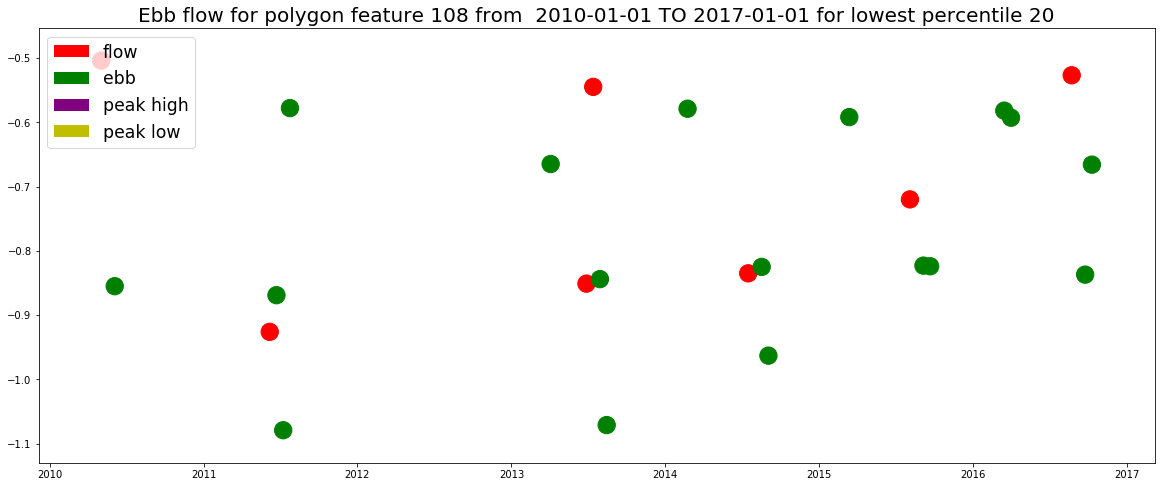

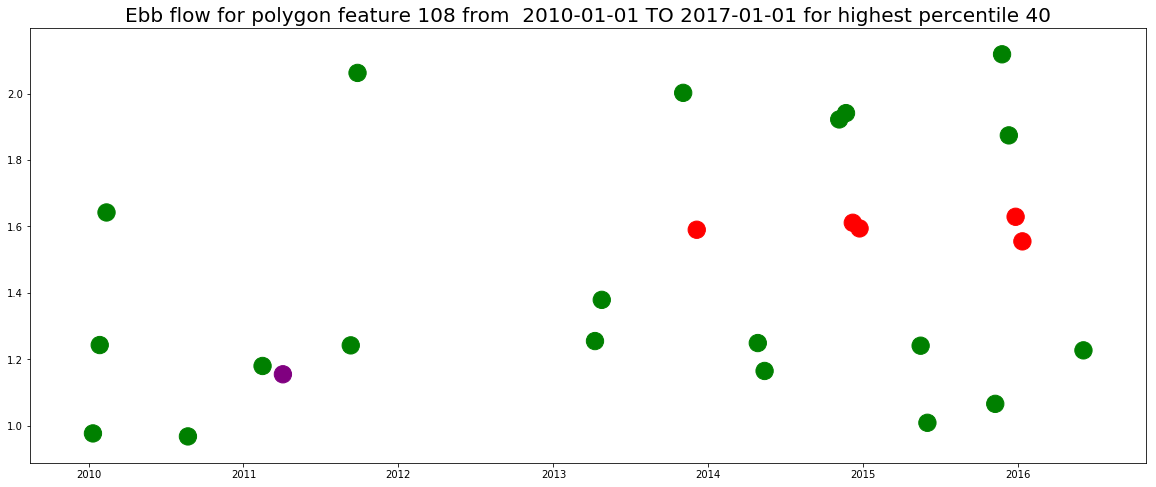

In [186]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.patches as mpatches


#todayTime=datetime.datetime.now();
#df = pd.DataFrame({'x': [todayTime+datetime.timedelta(hours=i) for i in range(10)], 'y': range(10),'z' : [2*j for j in range(10)]});
#xAlt=[0.5*i for i in range(10)];
fig = plt.figure()
fig.set_size_inches(20,8)
ax = fig.add_subplot(111)

classes = ['flow','ebb','peak high', 'peak low']
class_colours = ['r', 'g', 'purple', 'y']
recs = []

df5.low_date = pd.to_datetime(df5.low_date)
plt.scatter([x for x in df5.low_date], df5['low'], s=300, c=df5['efl'].apply(lambda x: col_dic[x]),
               label=df5['efl'].apply(lambda x: col_dic[x]), cmap = cm.jet)

for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=2, fontsize = 'xx-large')
#ax.scatter(df4['high_date'], df4['high'])
#plt.legend((ll), loc='upper left', numpoints=1, ncol=3, fontsize=8, scatterpoints=1)
plt.title('Ebb flow for polygon feature ' + str(Id) + ' from  ' + date_ranges[0].strftime("%Y-%m-%d") + ' TO ' + 
          date_ranges[1].strftime("%Y-%m-%d") + ' for lowest percentile ' + LOW_PER , fontsize=20)
plt.show()

fig = plt.figure()
fig.set_size_inches(20,8)
ax = fig.add_subplot(111)

df4.high_date = pd.to_datetime(df4.high_date)
plt.scatter([x for x in df4.high_date], df4['high'], s=300, c=df4['efh'].apply(lambda x: col_dic[x]),
               label=df4['efh'].apply(lambda x: col_dic[x]), cmap = cm.jet)

for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
#plt.legend(recs,classes,loc=2, fontsize = 'xx-large')
#ax.scatter(df4['high_date'], df4['high'])
#plt.legend((ll), loc='upper left', numpoints=1, ncol=3, fontsize=8, scatterpoints=1)
plt.title('Ebb flow for polygon feature ' + str(Id) + ' from  ' + date_ranges[0].strftime("%Y-%m-%d") + ' TO ' +
          date_ranges[1].strftime("%Y-%m-%d") + ' for highest percentile ' + PERCC, fontsize=20)
plt.show()